# Метод внутренней точки. Метод логарифмического барьера  

Цель - имея точку внутри области, заданной функциями ограничения, найти минимум целевой функции на этой области. Для этого воспользуемся логарифмическим барьером $-log(-f_i(x))$ для каждой функции ограничения $f_i(x)$. Такой логарифм является выпуклой функцией для выпуклых условий ограничения. В качестве функции будем рассматривать вместо $f(x)$ функцию $F(t, x) = t f(x) - \sum log(-f_i(x))$, где $t$ изначально выберем равным 2. Итерация алгоритма будет следующей: вычисляем методом Ньютона или каким-либо квазиньютоновским методом минимум $F(t, x)$ для фиксированного $t$, затем увеличиваем $t$ в $\mu$ раз. Тогда функция сойдётся к точке в области, где $f(x)$ будет минимальной.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import math
from scipy import optimize
import pylab
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [13]:
#секция констант

dim = 2
max_steps = 1000
precision = 0.0001
gamma1 = 0.2
alpha = 0.2
mu = 15
t0 = 2

h = np.ones(dim*dim)
h.shape = dim, dim
h[0][0] = 2

b = np.array([-1, 1])

x0 = np.array([-0.5, -0.2])

In [4]:
#секция функций и их градиентов (могут быть использованы в качестве ограничений)

def f(x):
    return x[0]**2 + 5*x[1]**2

def f1(x):
    return abs(x[0]**3 + 5*x[1]**3) - 90

def g(x):
    return 0.5*x.dot(h.dot(x)) - b.dot(x)   

def df(x):
    grad = np.zeros_like(x)
    grad[0] = 2*x[0]
    grad[1] = 10*x[1]
    return grad

def df1(x):
    grad = np.zeros_like(x)
    grad[0] = 3*x[0]**2
    grad[1] = 15*x[1]**2
    return grad

def dg(x):
    return h.dot(x) - b

def hf(x):
    m = np.zeros(dim*2)
    m.shape = dim, dim
    m[0][0] = 0.5
    m[1][1] = 0.1
    return m
    
def hf1(x):
    m = np.zeros(dim*2)
    m.shape = dim, dim
    m[0][0] = 1/(6*x[0])
    m[1][1] = 1/(30*x[1])
    return m

def hg(x):
    m = -np.ones(dim*2)
    m.shape = dim, dim
    m[0][0] = 1
    m[1][1] = 2
    return m

In [5]:
#секция ограничений

def f_1(x):
    return x[0]**2 + x[1]**2 - 90

def df_1(x):
    grad = np.zeros_like(x)
    grad[0] = 2*x[0]
    grad[1] = 2*x[1]
    return grad

def hf_1(x):
    m = np.zeros(dim*2)
    m.shape = dim, dim
    m[0][0] = 2
    m[1][1] = 2
    return m

def f_2(x):
    return x[0]**2 - x[1]

def df_2(x):
    grad = np.zeros_like(x)
    grad[0] = 2*x[0]
    grad[1] = 1
    return grad

def hf_2(x):
    m = np.zeros(dim*2)
    m.shape = dim, dim
    m[0][0] = 2
    return m

In [11]:
#вычисление градиента суммы логарифмов ограничений

def grad_for_barrier_phi(x, phi, phi_grad):
    res = 0
    for i in range(len(phi)):
        res -= phi_grad[i](x)/phi[i](x)
    return res

def grad_for_barrier(t, grad, phi, phi_grad):
    return lambda x : t*grad(x) + grad_for_barrier_phi(x, phi, phi_grad)

def hess_for_barrier_phi(x, phi, phi_grad, phi_hess):
    res = 0
    for i in range(len(phi)):
        grad_i_res = phi_grad[i](x)
        grad_i_res.shape = 1, dim
        res += (grad_i_res.T.dot(grad_i_res))/(phi[i](x))**2 - phi_hess[i](x)/phi[i](x)
    return res

def hess_for_barrier(t, hess, phi, phi_grad, phi_hess):
    return lambda x : t*hess(x) + hess_for_barrier_phi(x, phi, phi_grad, phi_hess)

In [19]:
def newton(x, grad, hess):
    next_x = x
    steps = []
    for i in range(max_steps):
        next_x = x - hess(x).dot(grad(x))
        if i%10 == 0:
            print('Step '+ str(i) + ' of Newton: x=' + str(next_x))
            steps.append(next_x)
        if np.linalg.norm(next_x - x) <= precision:
            break        
        x = next_x
    print()
    return next_x

#метод Ньютона дал большое расхождение, поэтому используем DFP

def dfp(x, grad):
    next_x = x
    b = gamma1*np.diag(np.full(dim, 1))
    for i in range(max_steps):
        next_x = x - alpha*b.dot(grad(x))
        s = next_x - x
        y = grad(next_x) - grad(x)
        K = b.dot(y)        
        K.shape = 1, dim
        s.shape = 1, dim
        y.shape = 1, dim
        b = b - (K.T.dot(K))/(y.dot(K.T)) + (s.T.dot(s))/(y.dot(s.T))
        if np.linalg.norm(next_x - x) <= precision:
            break        
        x = next_x
    return next_x

def barrier(x, f, grad, phi, phi_grad):
    t = t0
    next_x = x
    steps = []
    for i in range(max_steps):
        next_x = dfp(x, grad_for_barrier(t, grad, phi, phi_grad))
        if i%2 == 0:
            print('Step '+ str(i) + ' of log barrier: x=' + str(next_x))
            steps.append(next_x)
        if np.linalg.norm(f(next_x) - f(x)) <= precision:
            break        
        x = next_x
        t = mu*t
    print()
    return next_x, steps

In [29]:
x1, steps1 = barrier(x0, f, df, [f1], [df1])
x2, steps2 = barrier(x0, f, df, [f1, g], [df1, dg])
x3, steps3 = barrier(x0, f, df, [f_1], [df_1])
x4, steps4 = barrier(x0, f, df, [f_2], [df_2])
x5, steps5 = barrier(x0, f, df, [f_1, f_2], [df_1, df_2])

print()
print(x1, f(x1))
print(x2, f(x2))
print(x3, f(x3))
print(x4, f(x4))
print(x5, f(x5))

Step 0 of log barrier: x=[-3.44498726e-04 -3.03893382e-05]

Step 0 of log barrier: x=[ 0.57580736 -0.02446411]
Step 2 of log barrier: x=[-0.03004143  0.0065167 ]
Step 4 of log barrier: x=[-0.00224122  0.00063648]

Step 0 of log barrier: x=[-3.44804578e-04 -3.01604027e-05]

Step 0 of log barrier: x=[-0.77422292  0.09989961]
Step 2 of log barrier: x=[-2.57406078e-10 -2.63904795e-04]

Step 0 of log barrier: x=[0.77272414 0.10040489]
Step 2 of log barrier: x=[ 1.52394233e-08 -3.88273598e-03]


[3.68350688e-04 1.17785393e-05] 1.3637589937790537e-07
[-0.00224122  0.00063648] 7.048556315496937e-06
[3.68307282e-04 1.02595887e-05] 1.36176549981334e-07
[0.00425614 0.00014447] 1.821910135652959e-05
[-1.32263343e-02  3.02379106e-05] 0.00017494049038096422


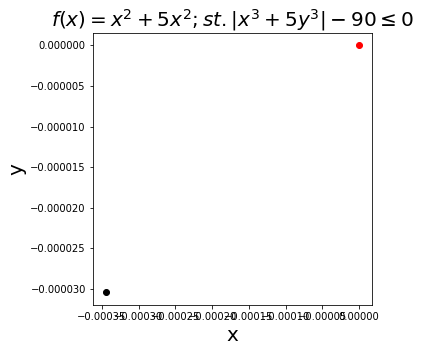

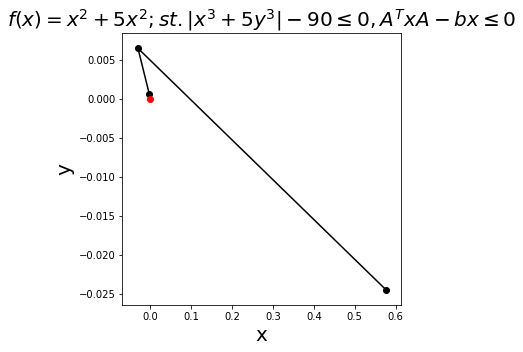

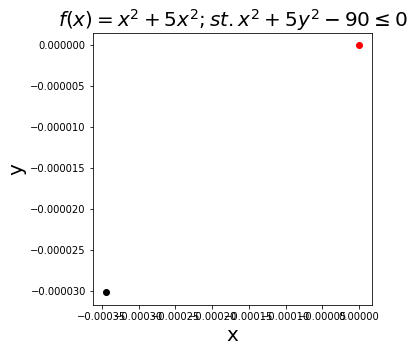

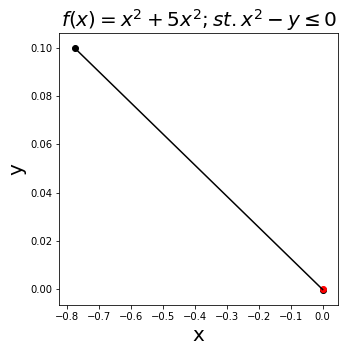

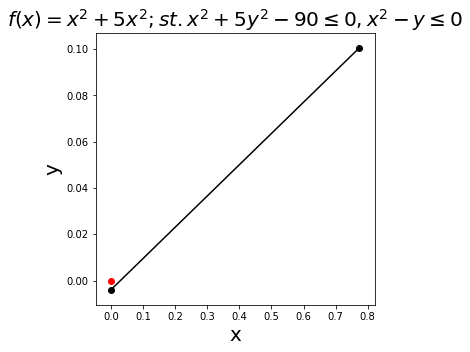

In [30]:
plt.figure(figsize=(5, 5))

plt.plot(np.array(steps1).T[0], np.array(steps1).T[1], color='black')
plt.scatter(np.array(steps1).T[0], np.array(steps1).T[1], color='black')
plt.scatter(0, 0, color='red')
plt.xlabel(r'x', fontsize=20)
plt.ylabel(r'y', fontsize=20)
plt.title(r'$f(x) = x^2 + 5 x^2; st. |x^3 + 5 y^3| - 90 \leq 0$', fontsize=20)

plt.figure(figsize=(5, 5))

plt.plot(np.array(steps2).T[0], np.array(steps2).T[1], color='black')
plt.scatter(np.array(steps2).T[0], np.array(steps2).T[1], color='black')
plt.scatter(0, 0, color='red')
plt.xlabel(r'x', fontsize=20)
plt.ylabel(r'y', fontsize=20)
plt.title(r'$f(x) = x^2 + 5 x^2; st. |x^3 + 5 y^3| - 90 \leq 0, A^T x A - b x \leq 0$', fontsize=20)

plt.figure(figsize=(5, 5))

plt.plot(np.array(steps3).T[0], np.array(steps3).T[1], color='black')
plt.scatter(np.array(steps3).T[0], np.array(steps3).T[1], color='black')
plt.scatter(0, 0, color='red')
plt.xlabel(r'x', fontsize=20)
plt.ylabel(r'y', fontsize=20)
plt.title(r'$f(x) = x^2 + 5 x^2; st. x^2 + 5 y^2 - 90 \leq 0$', fontsize=20)

plt.figure(figsize=(5, 5))

plt.plot(np.array(steps4).T[0], np.array(steps4).T[1], color='black')
plt.scatter(np.array(steps4).T[0], np.array(steps4).T[1], color='black')
plt.scatter(0, 0, color='red')
plt.xlabel(r'x', fontsize=20)
plt.ylabel(r'y', fontsize=20)
plt.title(r'$f(x) = x^2 + 5 x^2; st. x^2 - y \leq 0$', fontsize=20)

plt.figure(figsize=(5, 5))

plt.plot(np.array(steps5).T[0], np.array(steps5).T[1], color='black')
plt.scatter(np.array(steps5).T[0], np.array(steps5).T[1], color='black')
plt.scatter(0, 0, color='red')
plt.xlabel(r'x', fontsize=20)
plt.ylabel(r'y', fontsize=20)
plt.title(r'$f(x) = x^2 + 5 x^2; st. x^2 + 5 y^2 - 90 \leq 0, x^2 - y \leq 0$', fontsize=20)

plt.show()

In [31]:
x1, steps1 = barrier(x0, f1, df, [f], [df])
x2, steps2 = barrier(x0, f1, df, [f, g], [df, dg])
x3, steps3 = barrier(x0, f1, df, [f_1], [df_1])
x4, steps4 = barrier(x0, f1, df, [f_2], [df_2])
x5, steps5 = barrier(x0, f1, df, [f_1, f_2], [df_1, df_2])

print()
print(x1, f(x1))
print(x2, f(x2))
print(x3, f(x3))
print(x4, f(x4))
print(x5, f(x5))

Step 0 of log barrier: x=[-0.5092877 -0.2190028]
Step 2 of log barrier: x=[ 0.04170854 -0.01018386]

Step 0 of log barrier: x=[ 0.93284616 -0.00498213]
Step 2 of log barrier: x=[-0.05144577  0.01157176]
Step 4 of log barrier: x=[-0.00344159  0.0011424 ]

Step 0 of log barrier: x=[-3.44804578e-04 -3.01604027e-05]

Step 0 of log barrier: x=[-0.77422292  0.09989961]
Step 2 of log barrier: x=[-2.57406078e-10 -2.63904795e-04]

Step 0 of log barrier: x=[0.77272414 0.10040489]
Step 2 of log barrier: x=[ 1.52394233e-08 -3.88273598e-03]


[-0.00771715  0.00446195] 0.00015909948546835974
[-0.00344159  0.0011424 ] 1.8369967107965982e-05
[3.68307282e-04 1.02595887e-05] 1.36176549981334e-07
[0.00425614 0.00014447] 1.821910135652959e-05
[-1.32263343e-02  3.02379106e-05] 0.00017494049038096422


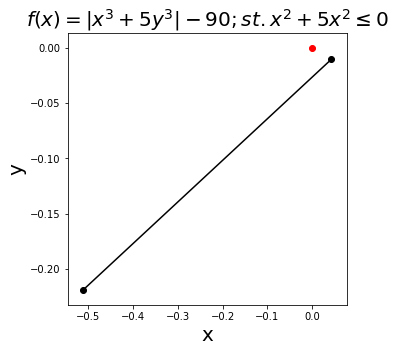

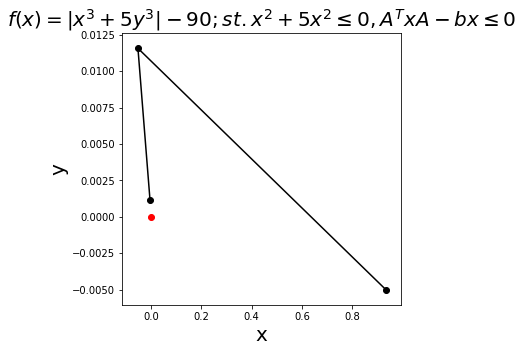

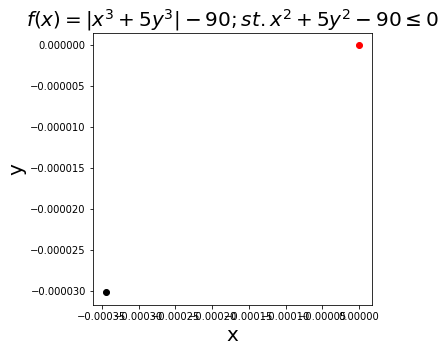

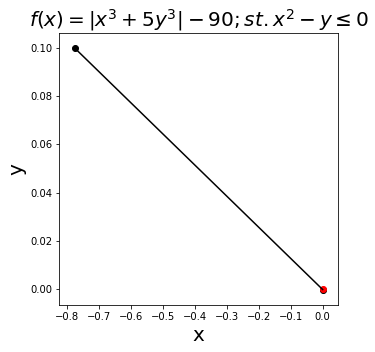

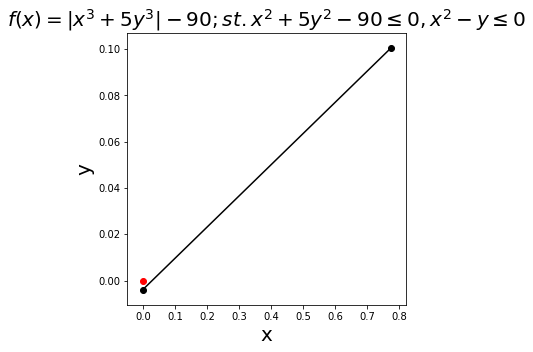

In [32]:
plt.figure(figsize=(5, 5))

plt.plot(np.array(steps1).T[0], np.array(steps1).T[1], color='black')
plt.scatter(np.array(steps1).T[0], np.array(steps1).T[1], color='black')
plt.scatter(0, 0, color='red')
plt.xlabel(r'x', fontsize=20)
plt.ylabel(r'y', fontsize=20)
plt.title(r'$f(x) = |x^3 + 5 y^3| - 90; st. x^2 + 5 x^2 \leq 0$', fontsize=20)

plt.figure(figsize=(5, 5))

plt.plot(np.array(steps2).T[0], np.array(steps2).T[1], color='black')
plt.scatter(np.array(steps2).T[0], np.array(steps2).T[1], color='black')
plt.scatter(0, 0, color='red')
plt.xlabel(r'x', fontsize=20)
plt.ylabel(r'y', fontsize=20)
plt.title(r'$f(x) = |x^3 + 5 y^3| - 90; st. x^2 + 5 x^2 \leq 0, A^T x A - b x \leq 0$', fontsize=20)

plt.figure(figsize=(5, 5))

plt.plot(np.array(steps3).T[0], np.array(steps3).T[1], color='black')
plt.scatter(np.array(steps3).T[0], np.array(steps3).T[1], color='black')
plt.scatter(0, 0, color='red')
plt.xlabel(r'x', fontsize=20)
plt.ylabel(r'y', fontsize=20)
plt.title(r'$f(x) = |x^3 + 5 y^3| - 90; st. x^2 + 5 y^2 - 90 \leq 0$', fontsize=20)

plt.figure(figsize=(5, 5))

plt.plot(np.array(steps4).T[0], np.array(steps4).T[1], color='black')
plt.scatter(np.array(steps4).T[0], np.array(steps4).T[1], color='black')
plt.scatter(0, 0, color='red')
plt.xlabel(r'x', fontsize=20)
plt.ylabel(r'y', fontsize=20)
plt.title(r'$f(x) = |x^3 + 5 y^3| - 90; st. x^2 - y \leq 0$', fontsize=20)

plt.figure(figsize=(5, 5))

plt.plot(np.array(steps5).T[0], np.array(steps5).T[1], color='black')
plt.scatter(np.array(steps5).T[0], np.array(steps5).T[1], color='black')
plt.scatter(0, 0, color='red')
plt.xlabel(r'x', fontsize=20)
plt.ylabel(r'y', fontsize=20)
plt.title(r'$f(x) = |x^3 + 5 y^3| - 90; st. x^2 + 5 y^2 - 90 \leq 0, x^2 - y \leq 0$', fontsize=20)

plt.show()

# Вывод

В большинстве случаев и для выпуклой, и для сильно выпуклой функции метод барьера сходится и находит нужную минимальную точку в заданной области с требуемой точностью. При этом он работает за сравнительно небольшое число шагов блягодаря эекпоненциальному увеличению параметра t. Однако во время реализации возникли проблемы с внедрением в метод барьера метода Ньютона и гессианом от суммы логарифмов, поэтому было принято решение использовать один из квазиньютоновских методов, замедляющий работу алгоритма, но всё ещё дающий достаточную скорость и точность сходимости. Приближение области логарифмическим барьером, как и было предсказано теоретически, позволяет искать точки только в множестве, ограниченном условиями.  

Таким образом метод внутренней точки показал себя как удобный и эффективный на практике и понятный теоретически метод решения задачи минимизации с условиями. Наибольшими проблемами стали метод Ньютона и вычисление градиента от логарифмов нескольких функций, одна из них была решена заменой метода аналогичным DFP, другая - отказом от вычисления гессиана и конструированием лямбда-функции от заданных условий. В результате сама функция барьерного метода принимает начальную точку, градиент целевой функции, а также массивы условий и их градиентов.  

Всё ещё остаётся проблемой задание начальной точки, лежащей в ограничиваемом множетсве, однако это решается уже другими методами, не входящими в состав барьерного метода.